In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier 
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier





TRAIN_DIR = "../data/processed/train"
TEST_DIR  = "../data/processed/test"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

c:\Users\mirei\Desktop\honeybee-detect-ML-\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
#load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
 TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(class_names) 
##only needed when training CNN and extracting features 


Found 1323 files belonging to 2 classes.
Using 1059 files for training.
Found 1323 files belonging to 2 classes.
Using 264 files for validation.
Found 331 files belonging to 2 classes.
['bumblebee', 'honeybee']


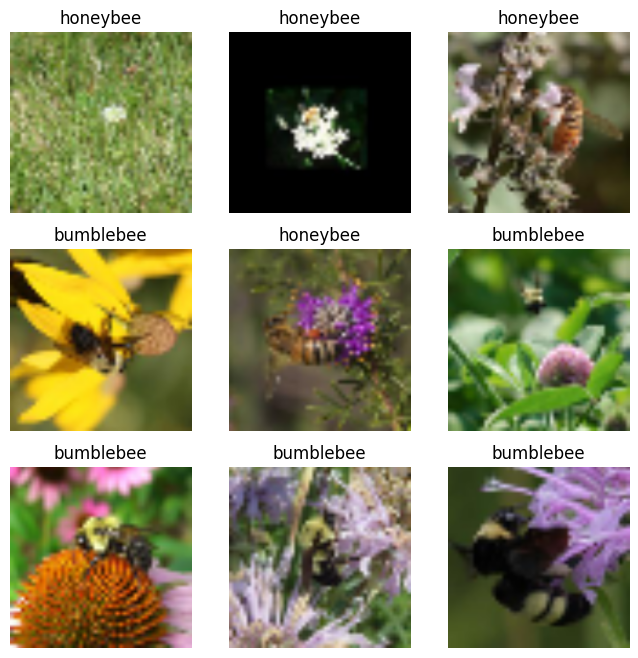

In [3]:
#visualize samples 
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [4]:
##feature extractor 


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

def extract_features(dataset):
    features = []
    labels = []

    for images, y in dataset:
        images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
        f = feature_extractor(images, training=False)
        features.append(f.numpy())
        labels.append(y.numpy())

    return np.vstack(features), np.concatenate(labels)

#EXTRACT FEATURES 
X_train, y_train = extract_features(train_ds)
X_val, y_val     = extract_features(val_ds)
X_test, y_test   = extract_features(test_ds)

## AFTER THIS , WE SHOULD HAVE A NORMAL TUBULAR DATASET TO TRAIN ON ## 

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


In [5]:
feature_names = [f"f_{i}" for i in range(X_train.shape[1])]

df_features = pd.DataFrame(X_train, columns=feature_names)
df_features["label"] = y_train

df_features.head()


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_1271,f_1272,f_1273,f_1274,f_1275,f_1276,f_1277,f_1278,f_1279,label
0,0.103633,0.511266,0.0,0.0,0.174767,1.468837,0.059152,0.000000,0.005404,0.000000,...,0.000000,0.026456,0.051136,0.458875,0.000000,0.879508,0.072154,0.0,0.000000,0
1,0.000000,0.000000,0.0,0.0,0.000000,0.401752,0.000000,0.005369,0.047453,0.000000,...,0.549114,1.088517,0.283730,1.330019,0.000000,0.119460,0.465236,0.0,0.622597,0
2,0.363550,1.695290,0.0,0.0,0.377449,1.201728,1.636232,0.004802,0.000000,0.133205,...,0.000000,0.095029,0.538919,2.465190,0.007001,0.024862,0.276156,0.0,0.000000,0
3,0.000000,0.813927,0.0,0.0,1.187262,0.232843,0.000000,0.000000,0.015126,0.122745,...,0.044689,0.118269,1.164375,1.392860,0.000000,0.243142,1.576480,0.0,0.160013,0
4,0.000000,1.884016,0.0,0.0,0.000000,0.002572,0.681965,0.225910,0.000000,0.007431,...,0.343215,0.057791,0.072690,0.229341,0.000000,1.187162,1.133670,0.0,0.913409,1


In [6]:
print("Samples:", df_features.shape[0])
print("Features:", df_features.shape[1] - 1)

Samples: 1059
Features: 1280


In [7]:
df_features.describe()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_1271,f_1272,f_1273,f_1274,f_1275,f_1276,f_1277,f_1278,f_1279,label
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,0.192138,1.020023,0.011199,0.009001,0.327913,0.479041,0.264888,0.133490,0.078802,0.034417,...,0.160193,0.701670,0.366768,0.937945,0.070738,0.322798,0.475935,0.041602,0.716651,0.495751
std,0.358265,0.867287,0.068596,0.056164,0.426214,0.554950,0.391270,0.292451,0.168745,0.114374,...,0.296991,0.692208,0.471060,0.840648,0.181911,0.405083,0.534313,0.149109,0.637889,0.500218
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.306750,0.000000,0.000000,0.022040,0.072556,0.003305,0.000000,0.000000,0.000000,...,0.000000,0.113021,0.022541,0.262986,0.000000,0.014637,0.037455,0.000000,0.178611,0.000000
50%,0.023964,0.834731,0.000000,0.000000,0.140610,0.261145,0.096784,0.000000,0.000000,0.000000,...,0.023734,0.481328,0.175287,0.714237,0.000000,0.150138,0.259569,0.000000,0.576045,0.000000
75%,0.216318,1.536341,0.000000,0.000000,0.496378,0.715657,0.384531,0.115989,0.075766,0.008202,...,0.163556,1.135664,0.537058,1.452047,0.041791,0.502650,0.803745,0.001964,1.101741,1.000000
max,2.659489,5.779139,1.678292,0.946926,2.408541,2.865617,3.018339,2.144396,1.221952,1.494333,...,2.033633,4.312214,3.736698,4.944998,2.335816,2.200219,2.367889,2.077913,3.241300,1.000000


In [8]:
df_features.to_csv("mobilenet_features_train.csv", index=False) 
#save training features to csv


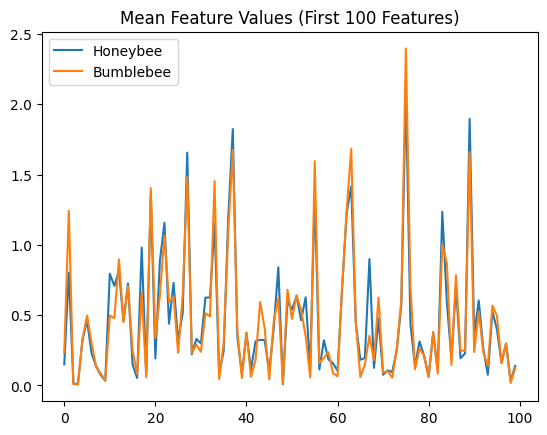

In [9]:
##Shows feature differences between classes
honeybee_mean = np.mean(X_train[y_train == 0], axis=0)
bumblebee_mean = np.mean(X_train[y_train == 1], axis=0)

plt.plot(honeybee_mean[:100], label="Honeybee")
plt.plot(bumblebee_mean[:100], label="Bumblebee")
plt.legend()
plt.title("Mean Feature Values (First 100 Features)")
plt.show()

In [10]:
df = pd.read_csv("mobilenet_features_train.csv")
X = df.drop("label", axis=1).values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
print("Class distribution:", np.bincount(y_train))

Class distribution: [427 420]


In [12]:
#preprocessing
# Remove features that are almost always zero
var_thresh = VarianceThreshold(threshold=0.01)

X_train_var = var_thresh.fit_transform(X_train)
X_test_var  = var_thresh.transform(X_test)

# feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_var)
X_test_scaled  = scaler.transform(X_test_var)


# PCA
pca_dims = [64, 128, 256, 384]

for n in pca_dims:
    print(f"\n🔹 PCA components: {n}")

    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    svm = SVC(kernel="rbf", C=10, gamma="scale")
    svm.fit(X_train_pca, y_train)

    y_pred = svm.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")

print("Original features:", X_train.shape[1])
print("After PCA:", X_train_pca.shape[1])


🔹 PCA components: 64
Accuracy: 0.7972

🔹 PCA components: 128
Accuracy: 0.8066

🔹 PCA components: 256
Accuracy: 0.7972

🔹 PCA components: 384
Accuracy: 0.8019
Original features: 1280
After PCA: 384


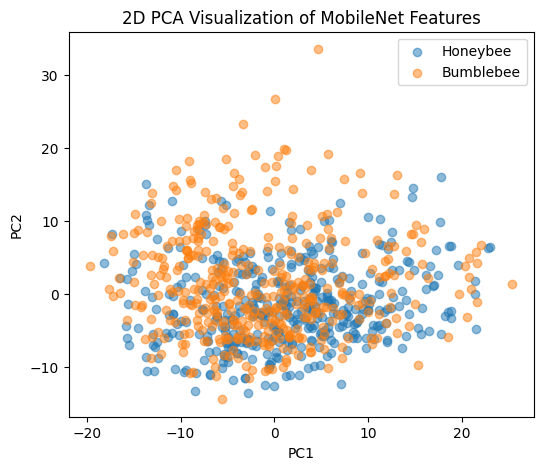

In [13]:
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[y_train == 0, 0], X_2d[y_train == 0, 1], alpha=0.5, label="Honeybee")
plt.scatter(X_2d[y_train == 1, 0], X_2d[y_train == 1, 1], alpha=0.5, label="Bumblebee")
plt.legend()
plt.title("2D PCA Visualization of MobileNet Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [14]:
results = []

In [15]:
#SVM CLASSIFIER
param_grid = {
    "C": [0.1, 1, 10, 50],
    "gamma": ["scale", 0.01, 0.001]
}

svm = SVC(kernel="rbf")

grid = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_pca, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

results.append({
    "Model": "SVM (RBF)",
    "Accuracy": accuracy_score(y_test, y_pred)
})

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10, 'gamma': 'scale'}
Best CV accuracy: 0.8323703445875392
SVM Accuracy: 0.8018867924528302
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       107
           1       0.78      0.83      0.81       105

    accuracy                           0.80       212
   macro avg       0.80      0.80      0.80       212
weighted avg       0.80      0.80      0.80       212



In [16]:
best_svm = grid.best_estimator_

y_pred = best_svm.predict(X_test_pca)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8018867924528302


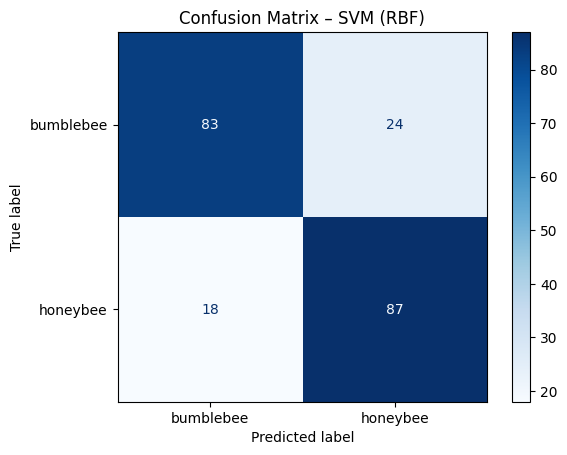

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – SVM (RBF)")
plt.show()

In [18]:
#XGBOOST CLASSIFIER

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train_var, y_train)

y_pred_xgb = xgb.predict(X_test_var)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred)
})

XGBoost Accuracy: 0.7641509433962265
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       107
           1       0.75      0.79      0.77       105

    accuracy                           0.76       212
   macro avg       0.76      0.76      0.76       212
weighted avg       0.77      0.76      0.76       212



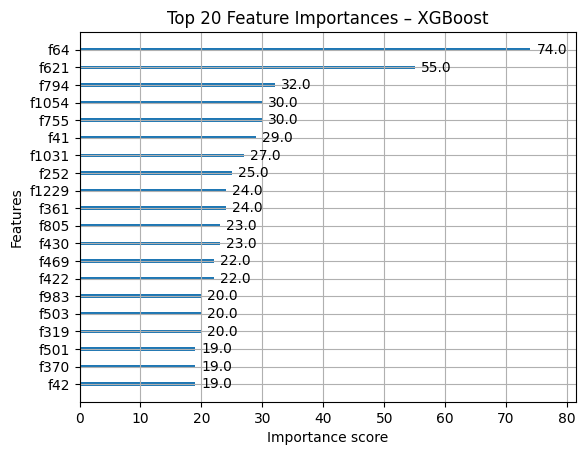

In [19]:
plot_importance(xgb, max_num_features=20)
plt.title("Top 20 Feature Importances – XGBoost")
plt.show()

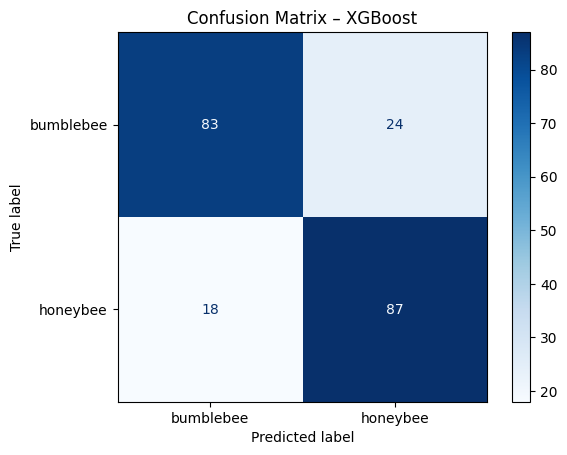

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost")
plt.show()

In [21]:

#Linear SVM

linear_svm = LinearSVC(
    C=1.0,
    max_iter=5000
)

linear_svm.fit(X_train_pca, y_train)

y_pred = linear_svm.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Linear SVM Accuracy:", acc)
print(classification_report(y_test, y_pred))

results.append({
    "Model": "Linear SVM",
    "Accuracy": acc
})

Linear SVM Accuracy: 0.7830188679245284
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       107
           1       0.77      0.81      0.79       105

    accuracy                           0.78       212
   macro avg       0.78      0.78      0.78       212
weighted avg       0.78      0.78      0.78       212



In [22]:
#Logistic Regression
logreg = LogisticRegression(
    max_iter=5000,
    C=1.0,
    solver="lbfgs"
)

logreg.fit(X_train_pca, y_train)

y_pred = logreg.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)
print(classification_report(y_test, y_pred))

results.append({
    "Model": "Logistic Regression",
    "Accuracy": acc
})

Logistic Regression Accuracy: 0.7830188679245284
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       107
           1       0.77      0.80      0.79       105

    accuracy                           0.78       212
   macro avg       0.78      0.78      0.78       212
weighted avg       0.78      0.78      0.78       212



In [23]:
dt = DecisionTreeClassifier(
    max_depth=10,        
    min_samples_split=10,
    random_state=42
)

dt.fit(X_train_scaled, y_train)

y_pred = dt.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", acc)
print(classification_report(y_test, y_pred))
results.append({
    "Model": "Decision Tree",
    "Accuracy": acc
})

Decision Tree Accuracy: 0.6367924528301887
              precision    recall  f1-score   support

           0       0.63      0.66      0.65       107
           1       0.64      0.61      0.62       105

    accuracy                           0.64       212
   macro avg       0.64      0.64      0.64       212
weighted avg       0.64      0.64      0.64       212



In [24]:
nb = GaussianNB()

nb.fit(X_train_pca, y_train)

y_pred = nb.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy:", acc)
print(classification_report(y_test, y_pred))
results.append({
    "Model": "Naive Bayes",
    "Accuracy": acc
})

Naive Bayes Accuracy: 0.6933962264150944
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       107
           1       0.72      0.62      0.67       105

    accuracy                           0.69       212
   macro avg       0.70      0.69      0.69       212
weighted avg       0.70      0.69      0.69       212



In [25]:
pd.DataFrame(results)


,Model,Accuracy
0,SVM (RBF),0.801887
1,XGBoost,0.801887
2,Linear SVM,0.783019
3,Logistic Regression,0.783019
4,Decision Tree,0.636792
5,Naive Bayes,0.693396


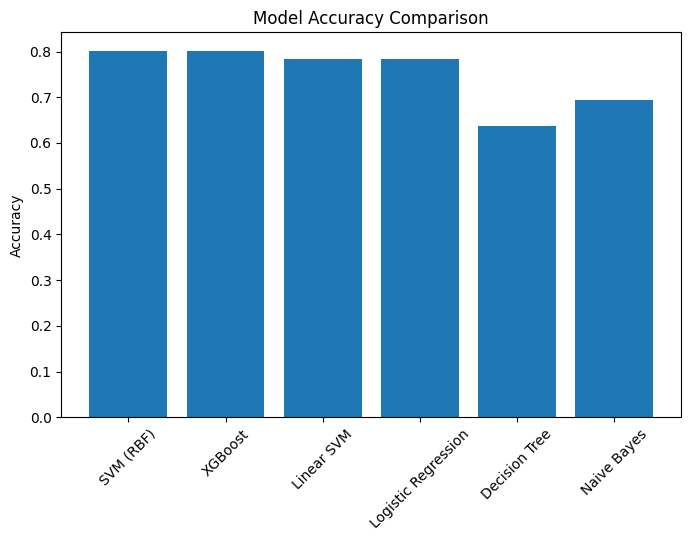

In [26]:
df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.bar(df_results["Model"], df_results["Accuracy"])
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

Random Forest Accuracy: 0.7358490566037735
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       107
           1       0.72      0.76      0.74       105

    accuracy                           0.74       212
   macro avg       0.74      0.74      0.74       212
weighted avg       0.74      0.74      0.74       212



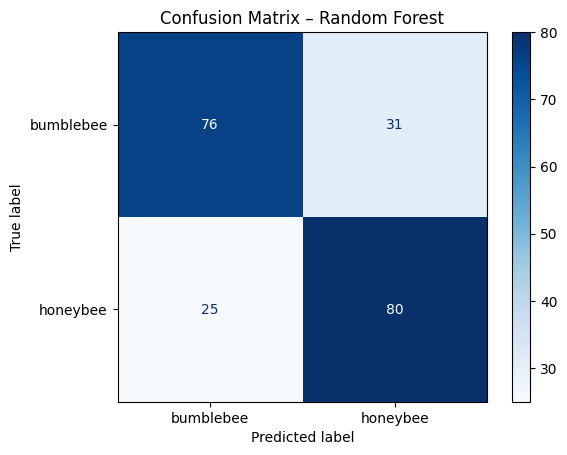

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=10,          # maximum depth of each tree
    min_samples_split=10,  # minimum samples to split a node
    random_state=42,
    n_jobs=-1
)

# Use the scaled features for Random Forest
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)
print(classification_report(y_test, y_pred_rf))

# Add to results list
results.append({
    "Model": "Random Forest",
    "Accuracy": acc_rf
})

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.show()


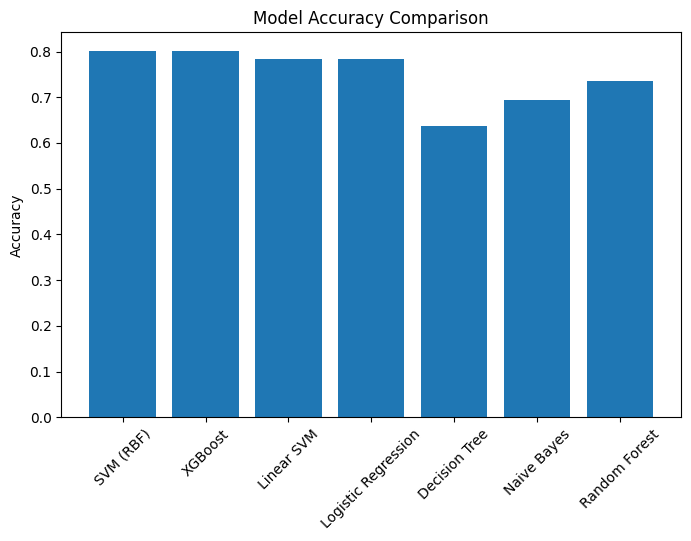

In [28]:
df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.bar(df_results["Model"], df_results["Accuracy"])
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


In [29]:
pd.DataFrame(results)


,Model,Accuracy
0,SVM (RBF),0.801887
1,XGBoost,0.801887
2,Linear SVM,0.783019
3,Logistic Regression,0.783019
4,Decision Tree,0.636792
5,Naive Bayes,0.693396
6,Random Forest,0.735849
